In [15]:
import numpyro
import numpy as np
import pandas as pd
from jax.nn import softmax
import jax.numpy as jnp

import rt_from_frequency_dynamics as rf

In [2]:
data_name = "omicron-us-split"
raw_cases = pd.read_csv(f"../data/{data_name}/{data_name}_location-case-counts.tsv", sep="\t")
raw_seq = pd.read_csv(f"../data/{data_name}/{data_name}_location-variant-sequence-counts.tsv", sep="\t")

In [3]:
# Locations to run
#locations = pd.unique(raw_seq["location"])
locations = ["Washington"]

In [4]:
# Defining Lineage Models
tau = 5.2 # Generation time
LM_MLR = rf.MultinomialLogisticRegression(tau)

In [5]:
# Params for fitting
opt = numpyro.optim.Adam(step_size=1e-2)
iters = 100_000
num_samples = 3000
save = False
load = False

# Running models and exporting results

In [7]:
def get_location_MLRData(rs, loc):
    rs_l = rs[rs.location==loc].copy()
    return rf.MLRData(rs_l)

In [8]:
def fit_SVI_locations(rs, locations, LM, opt, **fit_kwargs):
    n_locations = len(locations)
    MP = rf.MultiPosterior()
    for i, loc in enumerate(locations):
        VD = get_location_MLRData(rs, loc)
        PH = rf.fit_SVI(VD, LM, opt, name=loc, **fit_kwargs)
        MP.add_posterior(PH)
        print(f'Location {loc} finished ({i+1}/{n_locations}).')
    return MP

In [9]:
# Running GARW model
MP_MLR = fit_SVI_locations(raw_seq, locations, 
                             LM_MLR, opt, 
                             iters=iters, num_samples=num_samples, save=save, load=load, path=path_GARW)

Location Washington finished (1/1).


# Making forecasts

In [16]:
def posterior_frequency(dataset, X):
    """
    Use posterior beta to get posterior frequenicies based on matrix X.
    """
    beta = jnp.array(dataset.posterior["beta"])[1]
    logits = jnp.dot(X, beta) # Logit frequencies by variant
    return softmax(logits, axis=-1)

In [47]:
PH = MP_MLR.get("Washington") # Unpack posterior for Washington
VD = PH.data
last_T = len(VD.dates) # Get end of fitting period
forecast_L = 14 # How far ahead to forecast

# Creating feature matrices
X = LM_MLR.make_ols_feature(start=0, stop=last_T) 
X_forecast = LM_MLR.make_ols_feature(start=last_T, stop=last_T + forecast_L)

# Computing posterior frequencies
freq = posterior_frequency(PH.dataset, X)
freq_forecast = posterior_frequency(PH.dataset, X_forecast)

# Making figures

In [48]:
from rt_from_frequency_dynamics.plotfunctions import *
ps = DefaultAes.ps
alphas = DefaultAes.alphas

v_colors = ["#56e39f", "#89CFF0", "#C70039", "#808080"]
v_names = ['Delta', 'Omicron 21L', 'Omicron 21K', 'other']

color_map = {v : c for c, v in zip(v_colors, v_names)}

In [49]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

font = {'family' : 'Helvetica',
        'weight' : 'light',
        'size'   : 32}

matplotlib.rc('font', **font)

In [50]:
def plot_MLR_frequencies(ax, t, freq, ps, alphas, colors):
    
    # Compute quantiles
    V = []
    for p in ps:
        up = 1/2 + p/2
        lp = 1/2 - p/2
        Q = jnp.quantile(freq, jnp.array([lp,up]), axis=1)
        V.append(Q)
    med = jnp.median(freq, axis=1) # Compute median
    
    T, N_variant = med.shape
    # Make figure
    for variant in range(N_variant):
        for i in range(len(ps)):
            ax.fill_between(t, V[i][0, :, variant], V[i][1, :, variant],
                            color=colors[variant], alpha=alphas[i])
        ax.plot(t, med[:, variant],
                color=colors[variant])

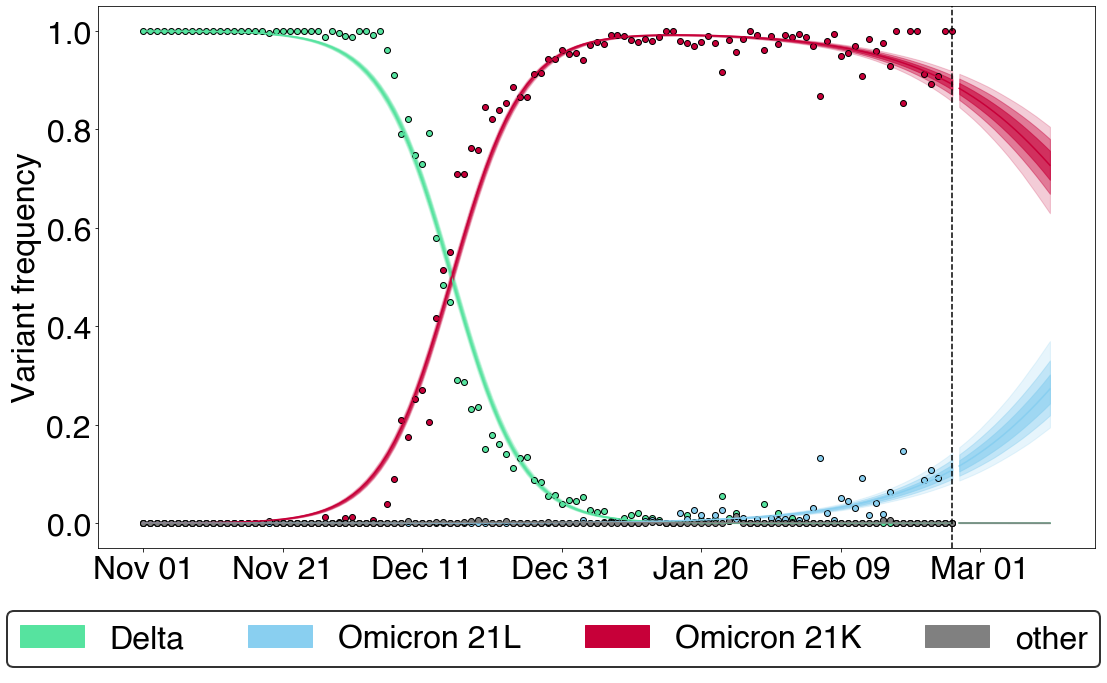

In [62]:
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])

colors = [color_map[v] for v in VD.seq_names] # Mapping colors to observed variants

# Plot predicted frequencies
plot_MLR_frequencies(ax, X[:,-1], freq, ps, alphas, colors)
plot_MLR_frequencies(ax, X_forecast[:,-1], freq_forecast, ps, alphas, colors)

rf.plot_observed_frequency(ax, VD, colors) # Plot observed frequencies

ax.axvline(x=len(VD.dates)-1, color='k', linestyle='--') # Adding forecast cut off
rf.add_dates_sep(ax, rf.expand_dates(VD.dates, forecast_L), sep=20) # Adding dates
ax.set_ylabel("Variant frequency") # Making ylabel


# Make legend
patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
legend.get_frame().set_linewidth(2.)
legend.get_frame().set_edgecolor("k")
fig.tight_layout()
fig.subplots_adjust(bottom = 0.2)